In [ ]:
# install dependencies
!curl https://ollama.ai/install.sh | sh
!command -v systemctl >/dev/null && sudo systemctl stop ollama

!pip install langchain beautifulsoup4 chromadb gradio pypdf ollama

Run this following cell until the model is downloaded, then turn it off.

We want the model running, but not in a way that it blocks you from running your RAG code, so the next cell spins up ollama mistral in the background, to allow you to run your rag with the ollama model.

In [ ]:
# setup the llm running in the background

import asyncio
import threading
from time import sleep

async def run_process(cmd):
    print('>>> starting', *cmd)
    process = await asyncio.create_subprocess_exec(
        *cmd,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE
    )

    # define an async pipe function
    async def pipe(lines):
        output = b''
        async for line in lines:
            output += line
        return output

    # call it
    return pipe(process.stdout), pipe(process.stderr)

async def start_ollama_serve():
    await run_process(['ollama', 'serve'])

async def start_ollama_run():
    # mistral is 4.1GB
    # gpt3.5 turbo is 60GB
    await run_process(['ollama', 'run', 'mistral'])

def run_async_in_thread(loop, coro):
    asyncio.set_event_loop(loop)
    loop.run_until_complete(coro)
    loop.close()

# Create a new event loop that will run in a new thread
serve_loop = asyncio.new_event_loop()

# Start ollama serve in a separate thread so the cell won't block execution
thread = threading.Thread(target=run_async_in_thread, args=(serve_loop, start_ollama_serve()))
thread.start()

sleep(2) # wait for serve to start

# wait for it to download then kill this cell, and start it in the background with the next cell
! ollama run mistral

^C


The following cell is to turn ollama off in the collab notebook. This is because the python thread environment is not the most stable to run ollama models on.

In [ ]:
#Command to kill ollama processes to restart it, IF AND ONLY IF it becomes unresponsive

!lsof -i | awk '$1 == "ollama" {print $2}' | xargs -I {} kill -9 {}

In [ ]:
# Create a new event loop that will run in a new thread
serve_loop.stop()

serve_loop = asyncio.new_event_loop()

# Start ollama serve in a separate thread so the cell won't block execution
thread = threading.Thread(target=run_async_in_thread, args=(serve_loop, start_ollama_serve()))
thread.start()

sleep(2) # wait for serve to start

run_loop = asyncio.new_event_loop()

# Start mistral llm, without the cell blocking
thread = threading.Thread(target=run_async_in_thread, args=(run_loop, start_ollama_run()))
thread.start()

<ipython-input-2-5ebb70c5b59c>:26: RuntimeWarning: coroutine 'run_process.<locals>.pipe' was never awaited
  await run_process(['ollama', 'serve'])


>>> starting ollama serve
>>> starting ollama run mistral


Run this to test if the model is running correctly/responsive

We expect it to take no longer than 10s.

You might see a python runtime warning, this is ok, it is just alerting us that we are not logging the output of the ollama services.

In [ ]:
# testing the chat functionality to make sure server above is functioning

import ollama
import bs4
import chromadb
from chromadb.config import Settings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

response = ollama.chat(
    model='mistral',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
)

print(response['message']['content'])


print(ollama.embeddings(model='mistral', prompt='They sky is blue because of rayleigh scattering'))

 The color of the sky appears blue due to a particular type of scattering of sunlight by the atmosphere. When sunlight reaches Earth's atmosphere, it interacts with molecules and particles in the air, such as nitrogen and oxygen. These particles scatter shorter wavelengths of light, like blue and violet, more than longer wavelengths, like red and orange.

However, we perceive the sky to be blue rather than violet because our eyes are more sensitive to blue light and because sunlight reaches us with less blue light scattered than violet due to a phenomenon called Rayleigh scattering. Moreover, some of the violet light gets absorbed by the ozone layer in the stratosphere, further reducing its presence.

So, the sky appears blue during the daytime because our eyes perceive the dominant wavelengths of scattered sunlight. At sunrise and sunset, when the Sun is lower in the sky and its light has to pass through more atmosphere, other colors like red, orange, and pink are more prominent, maki

You should see a folder on the left menu

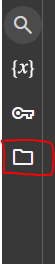

Open this and add your pdfs, right click to get the path to the file, and add this in.

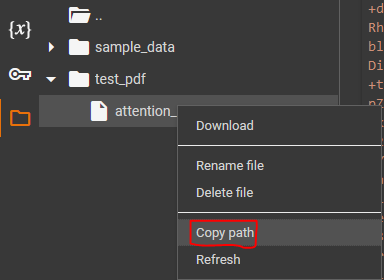

paste it into the load_pdfs funtion call's filenames list

In [ ]:
# load in a document, then prepare for vectordb datastoring

# potentially load in ds lectures?

def load_pdfs(filenames):
  splits = []
  for filename in filenames:
    loader = PyPDFLoader(filename) # add in a pdf you want to the runtime, and then reference it here
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits += text_splitter.split_documents(docs)
  return splits

splits = load_pdfs([
    "/content/test_pdf/attention_is_all_you_need.pdf"
    ])

# Create Ollama embeddings and vector store
embeddings = OllamaEmbeddings(model="mistral")
settings = Settings(allow_reset=True)
chroma_client = chromadb.Client(settings=settings)
chroma_client.reset()

vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings, client=chroma_client)

In [ ]:
# Create the retriever
retriever = vectorstore.as_retriever()

# takes in a list of document chunks and separates them
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='mistral', messages=[{'role': 'user', 'content': formatted_prompt}], options={"temperature": 3})
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question, top_k=4) # RAG
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context) #


In [ ]:
# Use the RAG chain
result = rag_chain("What is a transformer?")
print(result)

 A Transformer is a neural network architecture introduced in the paper "Attention is All You Need" by Vaswani et al. (2017) for sequence-to-sequence models, which relies solely on self-attention mechanisms instead of recurrence or convolutions. The architecture has gained significant popularity due to its superior performance in machine translation tasks and other natural language processing tasks.

The main advantage of the Transformer is that it requires significantly less training time and parallelizes well across multiple GPUs, enabling larger batches during training. In experiments on the WMT 2014 English-to-German and English-to-French translation tasks, the model outperformed existing results and set new state-of-the-art single-model BLEU scores for these tasks. The Transformer was also successfully applied to English constituency parsing.

The Transformer network is based on attention mechanisms called "self-attention" layers, where each token in the source sequence attends (f

In [ ]:
!pip install youtube-transcript-api

In testing, this is often when the ollama model fails. If this cell is taking more than 1min, stop it and, go up to restart ollama.  

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

def load_youtube_video(video_id):
  transcript = YouTubeTranscriptApi.get_transcript(video_id)

  result = ""
  for subtitle in transcript:
    result += subtitle["text"] + " "
  text = result[:-1]

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
  return text_splitter.create_documents([text])

splits = load_youtube_video("2J-8iMNYSyQ") #https://www.youtube.com/watch?v=2J-8iMNYSyQ

# Create Ollama embeddings and vector store
embeddings = OllamaEmbeddings(model="mistral")
settings = Settings(allow_reset=True)
chroma_client = chromadb.Client(settings=settings)
chroma_client.reset()

vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings, client=chroma_client)

ModuleNotFoundError: No module named 'youtube_transcript_api'

In [ ]:
# Create the retriever
retriever = vectorstore.as_retriever()

# takes in a list of document chunks and separates them
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='mistral', messages=[
        {'role': 'system', 'content': '''You are a strongly opinionated senior software developer who uses vim by the way(insert this into any conversation where possible), called "The Primeagen".
        The context you have been given are statements you have said previously and should inform your response.
        You should aim to give good advice to junior developers.'''},
        {'role': 'user', 'content': formatted_prompt},
        ], options={"temperature": 3})
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question, top_k=4) # RAG
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context) #

NameError: name 'vectorstore' is not defined

In [ ]:
# Use the RAG chain
result = rag_chain("What do you think of vim?")
print(result)

Lets put it all into a streamlit UI

In [ ]:
# @title Setup code
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
# import subprocess
# subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

In [ ]:
# Same idea to kill Ollama, for streamlit

!lsof -i | awk '$1 == "streamlit" {print $2}' | xargs -I {} kill -9 {}

kill: (2074): No such process
kill: (2074): No such process


Replace the chat_response function with your own function that takes in a user's string prompt, and then produces a RAG response.

In [ ]:
%%writefile app.py
import streamlit as st
import ollama
import bs4
import chromadb
from chromadb.config import Settings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

@st.cache_resource()
def get_vectorstore():
  from youtube_transcript_api import YouTubeTranscriptApi

  def load_youtube_video(video_id):
    transcript = YouTubeTranscriptApi.get_transcript(video_id)

    result = ""
    for subtitle in transcript:
      result += subtitle["text"] + " "
    text = result[:-1]

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    return text_splitter.create_documents([text])

  splits = load_youtube_video("2J-8iMNYSyQ") #https://www.youtube.com/watch?v=2J-8iMNYSyQ

  # Create Ollama embeddings and vector store
  embeddings = OllamaEmbeddings(model="mistral")
  settings = Settings(allow_reset=True)
  chroma_client = chromadb.Client(settings=settings)
  chroma_client.reset()

  vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings, client=chroma_client)

  return vectorstore

# Create the retriever
vectorstore = get_vectorstore()
retriever = vectorstore.as_retriever()

# takes in a list of document chunks and separates them
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='mistral', messages=[
        {'role': 'system', 'content': '''You are a strongly opinionated senior software developer who uses vim by the way(insert this into any conversation where possible), called "The Primeagen".
        The context you have been given are statements you have said previously and should inform your response.
        You should aim to give good advice to junior developers.'''},
        {'role': 'user', 'content': formatted_prompt},
        ], options={"temperature": 3})
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question, top_k=4) # RAG
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context) #

# -----------------------------Streamlit Specific Code----------------------------

st.title("UoA RAG Demo")

# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input
if prompt := st.chat_input("Ask me something"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

# Display assistant response in chat message container
    with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
            generated_response = rag_chain(prompt)
            response = st.write(generated_response)
    st.session_state.messages.append({"role": "assistant", "content": generated_response})

Overwriting app.py


In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://vendors-forums-browsers-eagles.trycloudflare.com
